In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline 
np.random.seed(1337)
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor

# Customer Lifetime Value Overview

__What is a Customer Lifetime Value (CLV)?__ Customer Lifetime Value is a monetary value that represents the amount of revenue or profit a customer will give the company over the period of the relationship. CLV demonstrates the implications of acquiring long-term customers compare to short-term customers.

__Customer Value__ = Average Order Value * Purchase Frequency

__CLV__ = (Customer Value/Churn Rate) x Profit margin.

__What is an Average Order Value(AOV)?__ The Average Order value is the ratio of your total revenue and the total number of orders. AOV represents the mean amount of revenue that the customer spends on an order. Average Order Value = Total Revenue / Total Number of Orders

__What is a Purchase Frequency(PF)?__ Purchase Frequency is the ratio of the total number of orders and the total number of customer. It represents the average number of orders placed by each customer. Purchase Frequency = Total Number of Orders / Total Number of Customers

__What is a Churn Rate?__ Churn Rate is the percentage of customers who have not ordered again.

__What is a Customer Lifetime?__ Customer Lifetime is the period of time that the customer has been continuously ordering. Customer Lifetime = 1 / Churn Rate

__What is a Repeat Rate?__ Repeat rate can be defined as the ratio of the number of customers with more than one order to the number of unique customers. Example: If you have 10 customers in a month out of who 4 come back, your repeat rate is 40%. 

__Repeat Rate__ = 1 - Churn Rate

# Loading Dataset

In [2]:
data = pd.read_csv('Customer_dataset.csv', encoding='ISO-8859-1', header=0)

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom


## Removing Duplicates

In [4]:
filtered_data=data[['Country','CustomerID']].drop_duplicates()

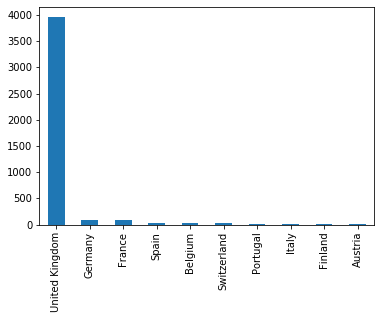

In [5]:
filtered_data.Country.value_counts()[:10].plot(kind='bar')

In [6]:
uk_data=data[data.Country=='United Kingdom']
uk_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495478 entries, 0 to 541893
Data columns (total 8 columns):
InvoiceNo      495478 non-null object
StockCode      495478 non-null object
Description    494024 non-null object
Quantity       495478 non-null int64
InvoiceDate    495478 non-null object
UnitPrice      495478 non-null float64
CustomerID     361878 non-null float64
Country        495478 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 34.0+ MB


In [7]:
uk_data.describe()

,Quantity,UnitPrice,CustomerID
count,495478.000000,495478.000000,361878.000000
mean,8.605486,4.532422,15547.871368
std,227.588756,99.315438,1594.402590
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,14194.000000
50%,3.000000,2.100000,15514.000000
75%,10.000000,4.130000,16931.000000
max,80995.000000,38970.000000,18287.000000


In [8]:
uk_data = uk_data[(uk_data['Quantity']>0)]
uk_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486286 entries, 0 to 541893
Data columns (total 8 columns):
InvoiceNo      486286 non-null object
StockCode      486286 non-null object
Description    485694 non-null object
Quantity       486286 non-null int64
InvoiceDate    486286 non-null object
UnitPrice      486286 non-null float64
CustomerID     354345 non-null float64
Country        486286 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.4+ MB


## Filter required Columns

In [9]:
uk_data=uk_data[['CustomerID','InvoiceDate','InvoiceNo','Quantity','UnitPrice']]

In [10]:
uk_data['InvoiceDate']=pd.to_datetime(uk_data['InvoiceDate'])

In [11]:
# Calulate total purchase
uk_data['TotalPurchase'] = uk_data['Quantity'] * uk_data['UnitPrice']

In [12]:
uk_data_group=uk_data.groupby('CustomerID').agg({'InvoiceDate': lambda date: (date.max() - date.min()).days,\
                                                 'InvoiceNo': lambda num: len(num),\
                                                 'Quantity': lambda quant: quant.sum(),\
                                                 'TotalPurchase': lambda price: price.sum()})

In [13]:
uk_data_group.head()

,InvoiceDate,InvoiceNo,Quantity,TotalPurchase
CustomerID,,,,
12346.0,0,1,74215,77183.60
12747.0,554,103,1275,4196.01
12748.0,692,4596,25748,33719.73
12749.0,312,199,1471,4090.88
12820.0,282,59,722,942.34


## Rename the column

In [14]:
# Change the name of columns
uk_data_group.columns=['num_days','num_transactions','num_units','spent_money']
uk_data_group.head()

,num_days,num_transactions,num_units,spent_money
CustomerID,,,,
12346.0,0,1,74215,77183.60
12747.0,554,103,1275,4196.01
12748.0,692,4596,25748,33719.73
12749.0,312,199,1471,4090.88
12820.0,282,59,722,942.34


# Calculate CLTV using following formula:

CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin.

Customer Value = Average Order Value * Purchase Frequency

### Calculate Average Order Value

In [15]:
# Average Order Value
uk_data_group['avg_order_value']=uk_data_group['spent_money']/uk_data_group['num_transactions']

In [16]:
uk_data_group.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value
CustomerID,,,,,
12346.0,0,1,74215,77183.60,77183.600000
12747.0,554,103,1275,4196.01,40.737961
12748.0,692,4596,25748,33719.73,7.336756
12749.0,312,199,1471,4090.88,20.557186
12820.0,282,59,722,942.34,15.971864


### Calculate Purchase Frequency

In [17]:
purchase_frequency=sum(uk_data_group['num_transactions'])/uk_data_group.shape[0]

### Calculate Repeat Rate and Churn Rate

In [18]:
# Repeat Rate
repeat_rate=uk_data_group[uk_data_group.num_transactions > 1].shape[0]/uk_data_group.shape[0]

In [19]:
# Churn Rate
churn_rate=1-repeat_rate

In [20]:
purchase_frequency,repeat_rate,churn_rate

(90.37107880642694, 0.9818923743942872, 0.018107625605712774)

### Calculate Profit Margin

In [21]:
# Profit Margin
margin=0.05
uk_data_group['profit_margin']=uk_data_group['spent_money']*margin

In [22]:
uk_data_group.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin
CustomerID,,,,,,
12346.0,0,1,74215,77183.60,77183.600000,3859.1800
12747.0,554,103,1275,4196.01,40.737961,209.8005
12748.0,692,4596,25748,33719.73,7.336756,1685.9865
12749.0,312,199,1471,4090.88,20.557186,204.5440
12820.0,282,59,722,942.34,15.971864,47.1170


### Calcualte Customer Lifetime Value

In [23]:
# Customer Value
uk_data_group['CLV']=(uk_data_group['avg_order_value']*purchase_frequency)/churn_rate

In [24]:
# Customer Lifetime Value
uk_data_group['customer_lifetime_value']=uk_data_group['CLV']*uk_data_group['profit_margin']

In [25]:
uk_data_group.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin,CLV,customer_lifetime_value
CustomerID,,,,,,,,
12346.0,0,1,74215,77183.60,77183.600000,3859.1800,3.852060e+08,1.486579e+12
12747.0,554,103,1275,4196.01,40.737961,209.8005,2.033140e+05,4.265538e+07
12748.0,692,4596,25748,33719.73,7.336756,1685.9865,3.661610e+04,6.173424e+07
12749.0,312,199,1471,4090.88,20.557186,204.5440,1.025963e+05,2.098545e+07
12820.0,282,59,722,942.34,15.971864,47.1170,7.971198e+04,3.755789e+06


# Prediction Model for CLTV

In [26]:
uk_data.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPurchase
0,17850.0,2010-01-12 08:26:00,536365,6,2.55,15.30
1,17850.0,2010-01-12 08:26:00,536365,6,3.39,20.34
2,17850.0,2010-01-12 08:26:00,536365,8,2.75,22.00
3,17850.0,2010-01-12 08:26:00,536365,6,3.39,20.34
4,17850.0,2010-01-12 08:26:00,536365,6,3.39,20.34


In [27]:
uk_data['month_yr'] = uk_data['InvoiceDate'].apply(lambda x: x.strftime('%b-%Y'))

In [28]:
uk_data.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPurchase,month_yr
0,17850.0,2010-01-12 08:26:00,536365,6,2.55,15.30,Jan-2010
1,17850.0,2010-01-12 08:26:00,536365,6,3.39,20.34,Jan-2010
2,17850.0,2010-01-12 08:26:00,536365,8,2.75,22.00,Jan-2010
3,17850.0,2010-01-12 08:26:00,536365,6,3.39,20.34,Jan-2010
4,17850.0,2010-01-12 08:26:00,536365,6,3.39,20.34,Jan-2010


In [29]:
sale=uk_data.pivot_table(index=['CustomerID'],columns=['month_yr'],values='TotalPurchase',aggfunc='sum',fill_value=0).reset_index()

In [30]:
sale.head()

month_yr,CustomerID,Apr-2011,Aug-2010,Aug-2011,Dec-2010,Dec-2011,Feb-2010,Feb-2011,Jan-2010,Jan-2011,...,Jun-2011,Mar-2010,Mar-2011,May-2010,May-2011,Nov-2011,Oct-2010,Oct-2011,Sep-2010,Sep-2011
0,12346.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,77183.60,...,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
1,12747.0,675.38,0.00,301.70,347.71,0.0,0.00,0.00,0.00,613.82,...,376.30,0.0,0.00,358.56,771.31,312.73,0.00,0.00,0.0,0.00
2,12748.0,1351.54,367.52,1926.85,809.80,538.3,4.25,673.06,4.95,666.94,...,2582.56,0.0,1148.78,966.40,1407.43,11339.11,1416.98,2369.79,136.2,4113.07
3,12749.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,1896.13,...,763.06,0.0,0.00,0.00,0.00,572.59,0.00,859.10,0.0,0.00
4,12820.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,170.46,...,210.35,0.0,0.00,0.00,0.00,0.00,0.00,343.76,0.0,217.77


In [31]:
sale['CLV']=sale.iloc[:,2:].sum(axis=1)

In [32]:
sale.head()

month_yr,CustomerID,Apr-2011,Aug-2010,Aug-2011,Dec-2010,Dec-2011,Feb-2010,Feb-2011,Jan-2010,Jan-2011,...,Mar-2010,Mar-2011,May-2010,May-2011,Nov-2011,Oct-2010,Oct-2011,Sep-2010,Sep-2011,CLV
0,12346.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,77183.60,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,77183.60
1,12747.0,675.38,0.00,301.70,347.71,0.0,0.00,0.00,0.00,613.82,...,0.0,0.00,358.56,771.31,312.73,0.00,0.00,0.0,0.00,3520.63
2,12748.0,1351.54,367.52,1926.85,809.80,538.3,4.25,673.06,4.95,666.94,...,0.0,1148.78,966.40,1407.43,11339.11,1416.98,2369.79,136.2,4113.07,32368.19
3,12749.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,1896.13,...,0.0,0.00,0.00,0.00,572.59,0.00,859.10,0.0,0.00,4090.88
4,12820.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,170.46,...,0.0,0.00,0.00,0.00,0.00,0.00,343.76,0.0,217.77,942.34


In [33]:
data_final=sale
data_final.columns.values

array(['CustomerID', 'Apr-2011', 'Aug-2010', 'Aug-2011', 'Dec-2010',
       'Dec-2011', 'Feb-2010', 'Feb-2011', 'Jan-2010', 'Jan-2011',
       'Jul-2010', 'Jul-2011', 'Jun-2010', 'Jun-2011', 'Mar-2010',
       'Mar-2011', 'May-2010', 'May-2011', 'Nov-2011', 'Oct-2010',
       'Oct-2011', 'Sep-2010', 'Sep-2011', 'CLV'], dtype=object)

In [34]:
X = data_final.loc[:, data_final.columns != 'CLV']
y = data_final.loc[:, data_final.columns == 'CLV']
y=y.astype('int') 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns1= X_train.columns
os_data_X = pd.DataFrame(data=X_train,columns=columns1)
os_data_y= pd.DataFrame(data=y_train,columns=['CLV'])

# Recursive Feature Elimination

In [35]:
linreg = LinearRegression()
rfe = RFE(linreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False False  True  True  True  True  True  True  True  True  True  True
  True  True False  True  True  True  True  True  True  True  True]
[4 3 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1]


In [36]:
data_X2 = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rfe.ranking_},)
data_X2.sort_values(by=['Importance'])

,Feature,Importance
11,Jul-2011,1
20,Oct-2011,1
19,Oct-2010,1
18,Nov-2011,1
17,May-2011,1
16,May-2010,1
15,Mar-2011,1
13,Jun-2011,1
12,Jun-2010,1
21,Sep-2010,1


In [37]:
col=[]
for i in range (0, len(data_X2["Importance"])):
    if data_X2["Importance"][i] == 1:
        col.append(data_X2["Feature"][i])
print(col)
print(len(col))

['Aug-2010', 'Aug-2011', 'Dec-2010', 'Dec-2011', 'Feb-2010', 'Feb-2011', 'Jan-2010', 'Jan-2011', 'Jul-2010', 'Jul-2011', 'Jun-2010', 'Jun-2011', 'Mar-2011', 'May-2010', 'May-2011', 'Nov-2011', 'Oct-2010', 'Oct-2011', 'Sep-2010', 'Sep-2011']
20


In [38]:
X=os_data_X[col]
y=os_data_y['CLV']

# Implementing the model

In [39]:
# Add a constant to the independent value
X1 = sm.add_constant(X)
# make regression model 
lin_model=sm.OLS(y,X1)
result=lin_model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    CLV   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.511e+06
Date:                Fri, 10 Apr 2020   Prob (F-statistic):               0.00
Time:                        00:35:56   Log-Likelihood:                -15351.
No. Observations:                2744   AIC:                         3.074e+04
Df Residuals:                    2723   BIC:                         3.087e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3619      1.357      0.267      0.7

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [40]:
pvalue = pd.DataFrame(result.pvalues,columns={'p_value'},)
pvalue

,p_value
const,7.897506e-01
Aug-2010,0.000000e+00
Aug-2011,0.000000e+00
Dec-2010,0.000000e+00
Dec-2011,0.000000e+00
Feb-2010,0.000000e+00
Feb-2011,0.000000e+00
Jan-2010,0.000000e+00
Jan-2011,0.000000e+00
Jul-2010,0.000000e+00


In [41]:
pvs=[]
for i in range (0, len(pvalue["p_value"])):
    if pvalue["p_value"][i] < 0.05:
        pvs.append(pvalue.index[i])
print(pvs)
print(len(pvs))  

['Aug-2010', 'Aug-2011', 'Dec-2010', 'Dec-2011', 'Feb-2010', 'Feb-2011', 'Jan-2010', 'Jan-2011', 'Jul-2010', 'Jul-2011', 'Jun-2010', 'Jun-2011', 'Mar-2011', 'May-2010', 'May-2011', 'Nov-2011', 'Oct-2010', 'Oct-2011', 'Sep-2010', 'Sep-2011']
20


In [42]:
pvs1=[i for i in pvs if i not in 'const']
X=os_data_X[pvs1]
y=os_data_y['CLV']
if 'const' in pvs:
    X1 = sm.add_constant(X)
else:
    X1 = X
lin_model=sm.OLS(y,X1)
result=lin_model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                    CLV   R-squared (uncentered):                   1.018
Model:                            OLS   Adj. R-squared (uncentered):              1.018
Method:                 Least Squares   F-statistic:                             -7903.
Date:                Fri, 10 Apr 2020   Prob (F-statistic):                        1.00
Time:                        00:35:56   Log-Likelihood:                         -15351.
No. Observations:                2744   AIC:                                  3.074e+04
Df Residuals:                    2724   BIC:                                  3.086e+04
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [43]:
pvalue = pd.DataFrame(result.pvalues,columns={'p_value'},)
pvalue

,p_value
Aug-2010,0.000000e+00
Aug-2011,0.000000e+00
Dec-2010,0.000000e+00
Dec-2011,0.000000e+00
Feb-2010,0.000000e+00
Feb-2011,0.000000e+00
Jan-2010,0.000000e+00
Jan-2011,0.000000e+00
Jul-2010,0.000000e+00
Jul-2011,0.000000e+00


In [44]:
pvs2=[]
for i in range (0, len(pvalue["p_value"])):
    if pvalue["p_value"][i] < 0.05:
        pvs2.append(pvalue.index[i])
print(pvs2)
print(len(pvs2))  

['Aug-2010', 'Aug-2011', 'Dec-2010', 'Dec-2011', 'Feb-2010', 'Feb-2011', 'Jan-2010', 'Jan-2011', 'Jul-2010', 'Jul-2011', 'Jun-2010', 'Jun-2011', 'Mar-2011', 'May-2010', 'May-2011', 'Nov-2011', 'Oct-2010', 'Oct-2011', 'Sep-2010', 'Sep-2011']
20


In [45]:
pvs3=[i for i in pvs2 if i not in 'const']
X=os_data_X[pvs3]
y=os_data_y['CLV']
if 'const' in pvs2:
    X1 = sm.add_constant(X)
else:
    X1 = X
lin_model=sm.OLS(y,X1)
result=lin_model.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                    CLV   R-squared (uncentered):                   1.018
Model:                            OLS   Adj. R-squared (uncentered):              1.018
Method:                 Least Squares   F-statistic:                             -7903.
Date:                Fri, 10 Apr 2020   Prob (F-statistic):                        1.00
Time:                        00:35:56   Log-Likelihood:                         -15351.
No. Observations:                2744   AIC:                                  3.074e+04
Df Residuals:                    2724   BIC:                                  3.086e+04
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Train and Build a Linear Regression Model

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Calculate R squared

In [47]:
y_pred_l = regressor.predict(X_test)
print("Linear Regression R squared: ", "{:.2%}".format(regressor.score(X_test, y_test)))
print("In the Linear Regression model", "{:.2%}".format(regressor.score(X_test, y_test)), "of the variability in Y can be explained using X")

Linear Regression R squared:  99.99%
In the Linear Regression model 99.99% of the variability in Y can be explained using X


## Calculate root-mean-square error (RMSE)

In [48]:
lin_mse = mean_squared_error(y_pred_l, y_test)
lin_rmse = np.sqrt(lin_mse)
print('Linear Regression RMSE: ', '{:,}'.format(round(lin_rmse, 2)))
print("\nOur model was able to predict the CLV of every customer in the test set within USD", '{:,}'.format(round(lin_rmse, 2)) ,"of the real value.")

Linear Regression MAE: 5872.6949
Linear Regression RMSE:  76.63

Our model was able to predict the CLV of every customer in the test set within USD 76.63 of the real value.


# Random Forest

In [49]:
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

## Calculate R squared

In [50]:
print("Random Forest R squared: ", "{:.2%}".format(forest_reg.score(X_test, y_test)))
print("\nIn the Random Forest Regressor model", "{:.2%}".format(forest_reg.score(X_test, y_test)), "of the variability in Y can be explained using X")

Random Forest R squared:  42.85%

In the Random Forest Regressor model 42.85% of the variability in Y can be explained using X


## Calculate root-mean-square error (RMSE)

In [51]:
y_pred_f = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_pred_f, y_test)
forest_rmse = np.sqrt(forest_mse)
print('Random Forest RMSE: ', '{:,}'.format(round(forest_rmse, 2)))
print("\nOur model was able to predict the CLV of every customer in the test set within USD", '{:,}'.format(round(forest_rmse, 2)) ,"of the real  value.")

Random Forest RMSE:  5,313.29

Our model was able to predict the CLV of every customer in the test set within USD 5,313.29 of the real  value.


# Gradient Boosting

In [52]:
model = ensemble.GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

## Calculate R squared

In [53]:
print("Gradient Boosting R squared: ", "{:.2%}".format(model.score(X_test, y_test)))
print("\nIn the Gradient Boosting Regressor model", "{:.2%}".format(model.score(X_test, y_test)), "of the variability in Y can be explained using X")

Gradient Boosting R squared:  30.10%

In the Gradient Boosting Regressor model 30.10% of the variability in Y can be explained using X


## Calculate root-mean-square error (RMSE)

In [61]:
y_pred_g = model.predict(X_test)
model_mse = mean_squared_error(y_pred_g, y_test)
model_rmse = np.sqrt(model_mse)
print('Gradient Boosting RMSE: ', '{:,}'.format(round(model_rmse, 2)))

Gradient Boosting RMSE:  5,876.28


# Choosing The best Model

In [55]:
a = round(lin_mse, 2)
b = round(forest_mse, 2)
c = round(model_mse, 2)
d = round(lin_rmse, 2)
e = round(forest_rmse, 2)
f = round(model_rmse, 2)
g = "{:.2%}".format(regressor.score(X_test, y_test))
h = "{:.2%}".format(forest_reg.score(X_test, y_test))
i = "{:.2%}".format(model.score(X_test, y_test))

In [56]:
df_Summary = pd.DataFrame({'RMSE': [d, e, f],
                   'RSQUARE': [g, h, i]},
                  index=['Linear Regression', 'Random Forest Regressor', 'Gradient Boosting Regressor'])
df_Summary

,RMSE,RSQUARE
Linear Regression,76.63,99.99%
Random Forest Regressor,5313.29,42.85%
Gradient Boosting Regressor,5876.28,30.10%


In [57]:
df_Summary['RMSE'].min()

76.63

In [58]:
"I would consider the Linear Regression model as my final model"

'I would consider the Linear Regression model as my final model'

# Prediction

In [59]:
print(X_train.columns)

Index(['Aug-2010', 'Aug-2011', 'Dec-2010', 'Dec-2011', 'Feb-2010', 'Feb-2011',
       'Jan-2010', 'Jan-2011', 'Jul-2010', 'Jul-2011', 'Jun-2010', 'Jun-2011',
       'Mar-2011', 'May-2010', 'May-2011', 'Nov-2011', 'Oct-2010', 'Oct-2011',
       'Sep-2010', 'Sep-2011'],
      dtype='object', name='month_yr')


In [60]:
a = float(input("Please enter the revenue for Aug-2010:"))
b = float(input("Please enter the revenue for Aug-2011:"))
c = float(input("Please enter the revenue for Dec-2010:"))
d = float(input("Please enter the revenue for Dec-2011:"))
e = float(input("Please enter the revenue for Feb-2010:"))
f = float(input("Please enter the revenue for Feb-2011:"))
g = float(input("Please enter the revenue for Jan-2010:"))
h = float(input("Please enter the revenue for Jan-2011:"))
i = float(input("Please enter the revenue for Jul-2010:"))
j = float(input("Please enter the revenue for Jul-2011:"))
k = float(input("Please enter the revenue for Jun-2010:"))
l = float(input("Please enter the revenue for Jun-2011:"))
m = float(input("Please enter the revenue for Mar-2011:"))
n = float(input("Please enter the revenue for May-2010:"))
o = float(input("Please enter the revenue for May-2011:"))
p = float(input("Please enter the revenue for Nov-2011:"))
q = float(input("Please enter the revenue for Oct-2010:"))
r = float(input("Please enter the revenue for Oct-2011:"))
s = float(input("Please enter the revenue for Sep-2010:"))
t = float(input("Please enter the revenue for Sep-2011:"))
new_data = np.array([a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t]).reshape(1,-1)
new_pred=regressor.predict(new_data)
result = float(new_pred[0])
print("The CLV for the new customer is : $" ,round(result,2))

Please enter the revenue for Aug-2010:50
Please enter the revenue for Aug-2011:50
Please enter the revenue for Dec-2010:50
Please enter the revenue for Dec-2011:50
Please enter the revenue for Feb-2010:50
Please enter the revenue for Feb-2011:50
Please enter the revenue for Jan-2010:50
Please enter the revenue for Jan-2011:50
Please enter the revenue for Jul-2010:50
Please enter the revenue for Jul-2011:50
Please enter the revenue for Jun-2010:50
Please enter the revenue for Jun-2011:50
Please enter the revenue for Mar-2011:50
Please enter the revenue for May-2010:50
Please enter the revenue for May-2011:50
Please enter the revenue for Nov-2011:50
Please enter the revenue for Oct-2010:50
Please enter the revenue for Oct-2011:50
Please enter the revenue for Sep-2010:50
Please enter the revenue for Sep-2011:50
The CLV for the new customer is : $ 997.69
